# Using Xarray to Access NetCDF files

## Why NetCDF files?

1. Easy to use across a number of platforms: MATLAB, R, Python
2. Self-documenting (i.e. the meta data is in it)
3. Nice set of tools for "quick looks" and cross-file manipulations

### Meta Data

NetCDF Climate and Forecast (CF) Metadata Conventions, Version 1.6, 5 December, 2011.

http://cfconventions.org/Data/cf-conventions/cf-conventions-1.6/build/cf-conventions.html

Or the Salish Sea page: http://salishsea-meopar-tools.readthedocs.io/en/latest/netcdf4/index.html

A NetCDF Dataset consists of dimensions, variables and metadata.

**Dimensions** are typically time and space.  One dimension can be unlimited.  The others have defined sizes.

We typical use time, z (depth), y, x with time unlimited.

Each dimension should have metadata including:
* long name
* units
* for time origin and for depth which way increases(up or down)

**Variables** are the quantities recorded.  Their dimensions are specified but do not need to include all the dimensions of the Dataset.

Each variable should have metadata including:
* long name
* units

The dataset **meta data** should include all the information relating to where the data/results came from and how it was processed. Specifically
* decriptive title
* institution
* source
* methods
* history

NOAA has produced a data sharing standard, opendap/erddap that allows you to download many datasets as netCDF files.  We have used erddap to share our Salish Sea Model results: salishsea.eos.ubc.ca/erddap

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Tell it what file we want
grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetry2V1')

In [3]:
# Write out the meta data
print (grid)

<xarray.Dataset>
Dimensions:     (gridX: 398, gridY: 898)
Coordinates:
  * gridY       (gridY) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * gridX       (gridX) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Data variables:
    longitude   (gridY, gridX) float32 ...
    latitude    (gridY, gridX) float32 ...
    bathymetry  (gridY, gridX) float64 ...
Attributes:
    acknowledgement: MEOPAR, ONC, Compute Canada
    cdm_data_type: Grid
    comment: Bathymetry, Latitudes and Longitudes
    Conventions: CF-1.6, COARDS, ACDD-1.3
    coverage_content_type: modelResult
    creator_email: sallen@eos.ubc.ca
    creator_name: Salish Sea MEOPAR Project Contributors
    creator_url: https://salishsea-meopar-docs.readthedocs.org/
    drawLandMask: over
    history: [2016-02-05 16:35:19] Created dataset.
[2016-03-02 18:08:56] Changed all variables to zlib=True.
[2016-03-02 18:08:56] Added least_significant_digit=1 and fill_value=0 to bathymetry variable.
[2016-03-03 12:28:37

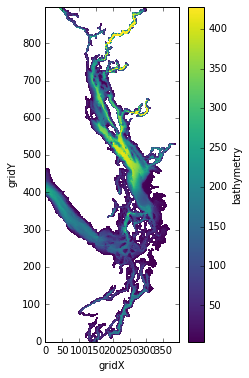

In [4]:
# plot the bathymetry
fig, ax = plt.subplots(figsize=(3, 6))
grid.bathymetry.plot(ax=ax)

In [5]:
# Lets get the 3-D tracer fields instead
tracers = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DTracerFields1hV1')

In [6]:
# Choose a small space slice
nemo_js = 125
nemo_je = 200
nemo_is = 650
nemo_ie = 720
j_slice = slice(nemo_js, nemo_je)
i_slice = slice(nemo_is, nemo_ie)
# and a time slice
time_slice = slice('2016-07-24 12:00:00', '2016-07-25 23:00:00')

In [7]:
sal_ts = (tracers.salinity.isel(gridY=i_slice, gridX=j_slice)
         .sel(time=time_slice))

print (sal_ts)

<xarray.DataArray 'salinity' (time: 35, depth: 40, gridY: 70, gridX: 75)>
[7350000 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2016-07-24T12:30:00 2016-07-24T13:30:00 ...
  * depth    (depth) float32 0.5 1.5 2.50001 3.50003 4.50007 5.50015 6.50031 ...
  * gridY    (gridY) int16 650 651 652 653 654 655 656 657 658 659 660 661 ...
  * gridX    (gridX) int16 125 126 127 128 129 130 131 132 133 134 135 136 ...
Attributes:
    colorBarMaximum: 37.0
    colorBarMinimum: 32.0
    interval_operation: 10.0
    interval_write: 3600.0
    ioos_category: Salinity
    long_name: salinity
    online_operation: ave(X)
    standard_name: sea_water_practical_salinity


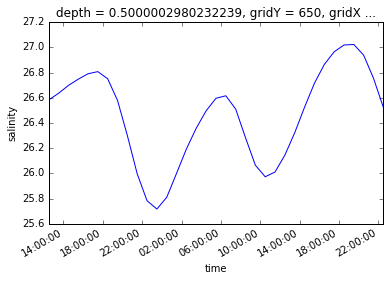

In [8]:
# use isel to select by index
salt_time = sal_ts.isel(gridX=0, gridY=0, depth=0)
salt_time.plot()

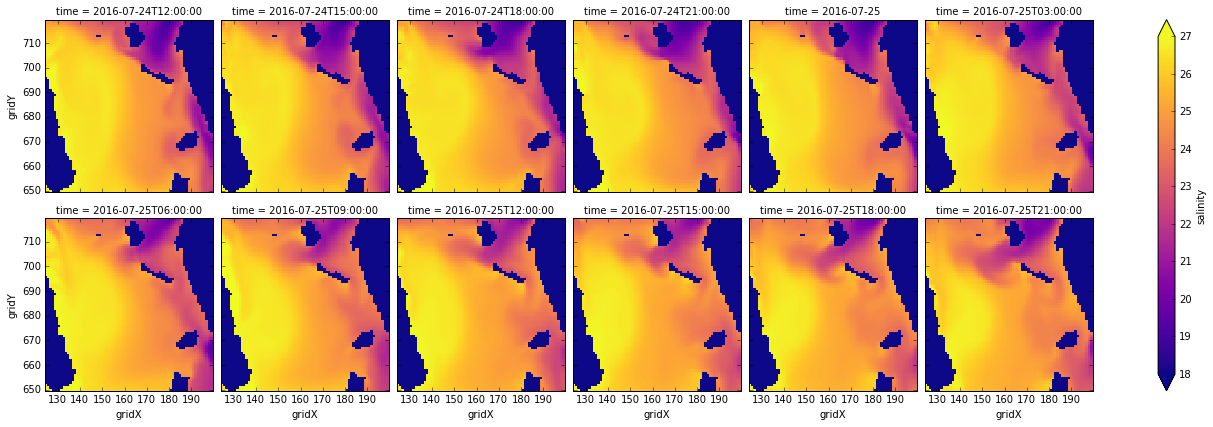

In [9]:
# use sel to select by value
# use cool pandas like attributes, like resample
salt_surf = (sal_ts.sel(depth=0, method='nearest')).resample('3h',dim='time')
# enhance your plot
salt_surf.plot(col='time', vmin=18, vmax=27, col_wrap=6, cmap='plasma')

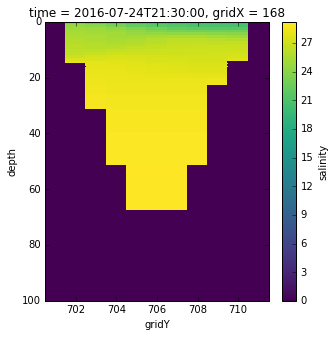

In [10]:
# lets zoom in to the gap between Savary and Hernando Island
short_slice = slice(701, 711)
salt_cross = (sal_ts.sel(gridX=168, gridY=short_slice).isel(time=9))
fig, ax = plt.subplots(1,1, figsize=(5,5))
salt_cross.plot(ax=ax)
ax.set_ylim((0,100))
ax.invert_yaxis()

In [11]:
# now lets calculate the freshwater flux between these two islands
u_vel = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DuVelocity1hV1')
u_ts = (u_vel.uVelocity.isel(gridY=short_slice, gridX=168).sel(time=time_slice))
s_ts = 30.-(tracers.salinity.isel(gridY=short_slice, gridX=168).sel(time=time_slice))


In [12]:
fresh_flux = (500.*u_ts*s_ts).sum(dim='gridY')

In [13]:
fresh_flux.name = 'FreshwaterFlux'
fresh_flux.attrs['units'] = 'm2/s'

In [14]:
print (fresh_flux)

<xarray.DataArray 'FreshwaterFlux' (time: 35, depth: 40)>
array([[-1089.31526255,   468.54568645,  2280.27027157, ...,
            0.        ,     0.        ,     0.        ],
       [-1849.1043996 ,   196.83620224,  2317.31367504, ...,
            0.        ,     0.        ,     0.        ],
       [-3900.56493143, -1007.96630415,  1397.70644363, ...,
            0.        ,     0.        ,     0.        ],
       ..., 
       [-9780.22681423, -9718.60296193, -8712.51023443, ...,
            0.        ,     0.        ,     0.        ],
       [-8862.59247147, -8252.42602749, -6660.54097273, ...,
            0.        ,     0.        ,     0.        ],
       [-7739.20174114, -6254.14633015, -4022.81488466, ...,
            0.        ,     0.        ,     0.        ]])
Coordinates:
  * time     (time) datetime64[ns] 2016-07-24T12:30:00 2016-07-24T13:30:00 ...
  * depth    (depth) float32 0.5 1.5 2.50001 3.50003 4.50007 5.50015 6.50031 ...
    gridX    int16 168
Attributes:
    units: m

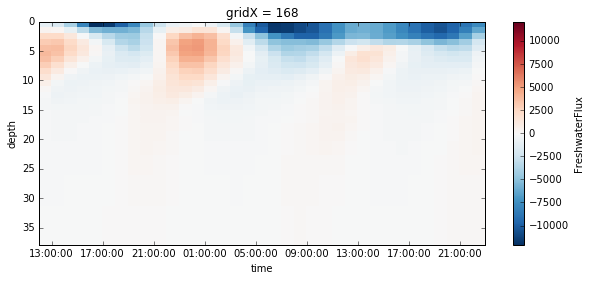

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
fresh_flux.sel(depth=slice(0,40)).plot(x='time', y='depth', yincrease=False, ax=ax)